#### Copy of SHAP Code but for barplot plots.

!pip install netCDF4
!pip install cmocean
!pip install investigate

In [1]:
##import the python functions from my NN file
from NN_arch524 import class_weight_creator
from NN_arch524 import input_output_data
from NN_arch524 import basic_ANN
from NN_arch524 import basic_ANNl2
from NN_arch524 import three_ANN
from NN_arch524 import four_ANN
from NN_arch524 import five_ANN

2024-10-08 21:56:02.741819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 21:56:02.741878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 21:56:02.741913: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 21:56:02.747516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from RNNdef_524 import build_lstm

In [3]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

In [4]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

In [5]:
tf.compat.v1.disable_eager_execution()
import investigate

In [6]:
##2-meter temperature anomaly classification 
#0; 0-25%
#1; 25-50%
#2; 50-75%
#3; 75-100%

#inputs ... CHANGE FOR WHATEVER YOU WANT TO LOOK AT 
infile = open("./data/NN_data/GL_DataAnom_class_14.p", 'rb') 
input = pickle.load(infile)
infile.close()

#outputs
infile = open("./data/NN_data/GL_tempclass_14.p", 'rb')
temp = pickle.load(infile)
infile.close()
#temp = temp.flatten()

#climo probabilities
#infile = open("./data/gl_3climoprob.p", 'rb')
#climo = pickle.load(infile)
#infile.close()

In [7]:
input.shape

(1727, 7, 9)

In [8]:
indices = np.isnan(input)

for val in indices:
    if np.any(val) != False:
        print("True")

In [9]:
input[0,:,1]

array([-0.55408303, -0.64515604, -0.79300354, -0.60441202, -0.58404081,
       -0.57805013, -0.47626018])

In [10]:
temp

array([1, 1, 1, ..., 1, 1, 1])

In [11]:
input = input.reshape((len(input[:,0,0]),63))

In [12]:
######
batch_size = 128 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [13]:
X_all = np.copy(input)
Y_all = np.copy(temp)
#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)

frac_validate = 0.2

In [14]:
X_all.shape

(1727, 63)

In [15]:
Y_all.shape

(1727, 2)

In [16]:
frac = round(len(input[:,0])*0.15)
frac

259

In [17]:
#numb_inputs1 = X_all.shape[1]
#numb_inputs2 = X_all.shape[2]
number_inputs =  X_all.shape[-1]

X_validation = X_all[0:int(frac)]
Y_validation = Y_all[0:int(frac)]
        
X_train = X_all[int(frac):len(X_all)-int(frac)]
Y_train = Y_all[int(frac):len(Y_all)-int(frac)]

X_test = X_all[len(X_all)-int(frac):]
Y_test = Y_all[len(Y_all)-int(frac):]

#Create class weights for training the model. If the dataset is unbalanced, this helps ensure the model
# does not simply start guessing the class that has more samples.
class_weight = class_weight_creator(Y_all)
model = three_ANN(number_inputs, 2, 64, 32, 16, 0.01, 0.005, 0.01, 0.005, 0.005, 0.001, 0.925, epochs)
#build_lstm(ntimestep, nfeature, numlayer, regval, neurons, numdenselayer, denseneurons, out_neurons, lr, recurr_dropout)
#model = build_lstm(numb_inputs1, numb_inputs2, 3, [1, 1, 0.05], [256,128,64], 1, [16], 2, 1, 0.1)
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose, class_weight=class_weight)
    
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Train on 1209 samples, validate on 259 samples
Epoch 1/50


2024-10-08 21:56:06.206309: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-08 21:56:06.232988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-10-08 21:56:06.264044: W tensorflow/c/c_api.cc:305] Operation '{name:'training/SGD/decay/Assign' id:512 op device:{requested: '', assigned: ''} def:{{{node training/SGD/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/SGD/decay, training/SGD/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an 

1209/1209 - 0s - loss: 10.3551 - categorical_accuracy: 0.5070 - val_loss: 6.5098 - val_categorical_accuracy: 0.5444 - 133ms/epoch - 110us/sample
Epoch 2/50
1209/1209 - 0s - loss: 5.1165 - categorical_accuracy: 0.6005 - val_loss: 3.6216 - val_categorical_accuracy: 0.5405 - 9ms/epoch - 7us/sample
Epoch 3/50
1209/1209 - 0s - loss: 2.9476 - categorical_accuracy: 0.5831 - val_loss: 2.2951 - val_categorical_accuracy: 0.5483 - 8ms/epoch - 7us/sample
Epoch 4/50
1209/1209 - 0s - loss: 1.9498 - categorical_accuracy: 0.5707 - val_loss: 1.6015 - val_categorical_accuracy: 0.5907 - 8ms/epoch - 7us/sample
Epoch 5/50
1209/1209 - 0s - loss: 1.4927 - categorical_accuracy: 0.6071 - val_loss: 1.3428 - val_categorical_accuracy: 0.6062 - 8ms/epoch - 7us/sample
Epoch 6/50
1209/1209 - 0s - loss: 1.2908 - categorical_accuracy: 0.6253 - val_loss: 1.2471 - val_categorical_accuracy: 0.5483 - 8ms/epoch - 7us/sample
Epoch 7/50
1209/1209 - 0s - loss: 1.1932 - categorical_accuracy: 0.6361 - val_loss: 1.1433 - val_cat

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-08 21:56:06.839175: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_3/Softmax' id:119 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

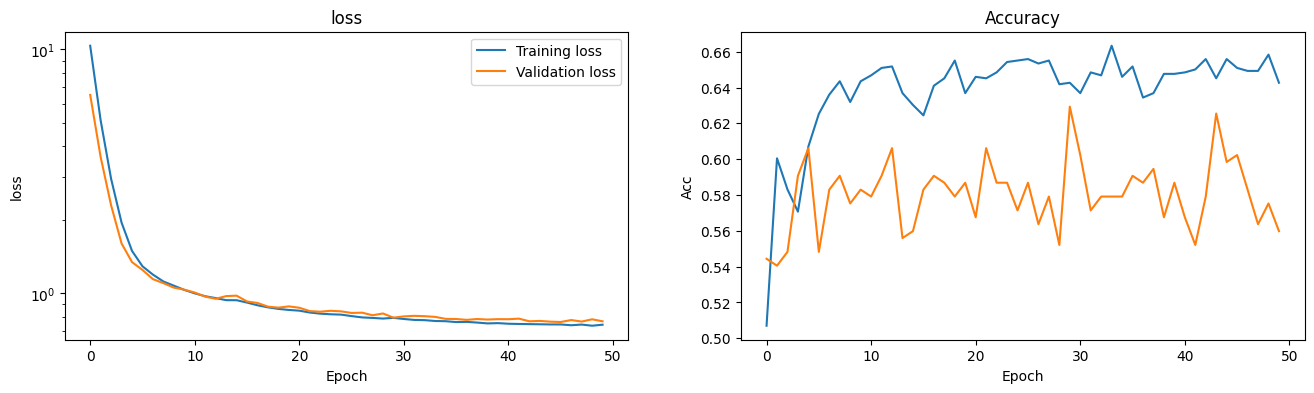

In [18]:
# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

In [19]:
import shap
import pylab

In [ ]:
shap_values_all = []
# explain predictions of the model on three images
#explainer = shap.DeepExplainer(model, X_train)
# ...or pass tensors directly
explainer = shap.Explainer(model.predict, X_train)
#X_vate = np.concatenate((X_val,X_test),axis=0)

In [ ]:
shap_values = explainer(X_train)
#shap_values_all.append(shap_values)
#print(np.shape(shap_values_all))

In [ ]:
shap_exp = shap_values
values = np.copy(shap_exp.values)

In [ ]:
values.shape

In [ ]:
shap_values_transposed = values.transpose(2, 0, 1)
shap_values_transposed.shape

In [ ]:
abs = np.abs(shap_values_transposed).shape #shape of absolute value
print(abs)

In [ ]:
aggs = np.abs(shap_values_transposed) ##aggregate over the samples
#aggs = shap_values_transposed
aggs.shape

In [ ]:
aggs = aggs.mean(axis=1)

In [ ]:
##loop through to properly group
sv = np.empty((2,9,10))

sv[:,0,:] = aggs[:,0::9]
sv[:,1,:] = aggs[:,1::9]
sv[:,2,:] = aggs[:,2::9]
sv[:,3,:] = aggs[:,3::9]
sv[:,4,:] = aggs[:,4::9]
sv[:,5,:] = aggs[:,5::9]
sv[:,6,:] = aggs[:,6::9]
sv[:,7,:] = aggs[:,7::9]
sv[:,8,:] = aggs[:,8::9]

In [ ]:
sv_true = sv.mean(axis=2) ##take mean along timestep axis
sv_true.shape

In [ ]:
sv_df = pd.DataFrame(sv_true.T)

In [ ]:
#feature_name = ['u10','size','ratio','clon','clat','ephi','ehf100','gph1000','ellipse']

In [ ]:
##i tailored the feature names to reflect the bar plot, 840516237
feature_name_bh = ['ellipse','size','ratio,','clat','u10','ephi','ehf100','clon','gph1000']

In [ ]:
fig = plt.figure(figsize=(15,10),dpi=100)
fig.suptitle("SHAP for Predicting Surface Temperature Extreme over Great Lakes at 0-days lead", fontsize = 18) 
 
ax1 = fig.add_subplot(1,1,1)
sv_df.loc[sv_df.sum(1).sort_values(ascending=True).index[-10:]].plot(
    kind="barh", stacked=True, ax = ax1, colormap = 'Paired')
ax1.tick_params(axis='both', which='major', labelsize= 18)
ax1.set_yticks([0,1,2,3,4,5,6,7,8],feature_name_bh)
ax1.set_xlabel('Mean SHAP value', fontsize =18 )
ax1.set_ylabel('Feature', fontsize =18 )
ax1.legend(loc = 'lower right', fontsize =18)
ax1.set_xlim(0,0.25)

plt.tight_layout()
plt.savefig('GL_SHAP_extremes.png')